## Installing

In [ ]:
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz


     |████████████████████████████████| 96.4 MB 86 kB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.0-py3-none-any.whl size=98072933 sha256=3f001654d6847f373d06c65ac008079f9be3342f2e0f9b51ad6eeb3cb54eb6cf
  Stored in directory: /root/.cache/pip/wheels/d1/e8/f9/fd0d324ec96ab55e0a8ae395183c22260a4eeaf166ade7ad22
Successfully built en-core-web-md


In [ ]:
import pandas as pd
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import spacy
from spacy.lang.en import English

import jieba
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.svm import SVC

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install textstat
import textstat

     |████████████████████████████████| 101 kB 9.6 MB/s 
     |████████████████████████████████| 2.0 MB 31.4 MB/s 


In [ ]:
from google.colab import files

In [ ]:
files = files.upload()

Saving twitter_train_combine.csv to twitter_train_combine.csv


In [ ]:
# Import data
twitter = pd.read_csv('twitter_train_combine.csv')

In [ ]:
# Evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Train a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

# Compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet':
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return results
    return best, best_name, classifier_comparison

In [ ]:
library_input = twitter['text']
library_input = [x.replace("  ", " ") for x in library_input]

twitter["word_count"] = [textstat.lexicon_count(x) for x in library_input]
twitter["sentence_count"] = [textstat.sentence_count(x) for x in library_input]
twitter["syllable_count"] = [textstat.syllable_count(x) for x in library_input]
twitter["difficult_words"] = [textstat.difficult_words(x) for x in library_input]
twitter["grade_level"] = [textstat.flesch_kincaid_grade(x) for x in library_input]
twitter["readability"] = [textstat.automated_readability_index(x) for x in library_input]

# 1. Preprosessing data
Divide data into a training set and a test set made up of 20% of the data.

In [ ]:
train, test = train_test_split(twitter, test_size=0.2, random_state=25)

In [ ]:
vocab_size = 1000

# By default build a unigram model - capturing individual words only
def ngrams(df, vocab_size = 1000, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size)
  X = vectorizer.fit_transform(df['text'])

# Make a dataframe with BOW model representations for each text
  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]

# Make the column names the words
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names

# Add Y labels to the dataFrame
  bow_df['sentiment'] = df['labels_A'].values
  return bow_df

In [ ]:
unigram_df = ngrams(train, max_n=1)
unigram_df

,0dyljrpsmx,10,100,10am,10million,10th,11am,12th,13th,14th,15pm,15th,16th,17,17th,19,1971,1st,20,200,2015,2015starqoutes,20th,22,227,23,25th,28th,29th,2e647hcr0h,2nd,2x,2xwmf7pdkw,30,30am,3rd,4th,50th,5dtcb4t3b0,5mhxgeouqt,...,wings,winner,winning,wins,wish,wishing,with,without,wivlbvuemz,woken,won,wore,world,worry,worth,would,wouldn,wright,write,wrong,wwe,wwerollins,xd,xrx1bglzcf,y5yyt08mgw,yakub,yeah,year,yeet,yeh9czfbgi,yes,yesterday,yoga,you,young,your,youtube,yum,zayn,sentiment
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,positive
156,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
158,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


In [ ]:
liwc_df = train.loc[:, ['text','labels_A']]
liwc_df['text_splits'] = [x.lower().split() for x in liwc_df['text']]

In [ ]:
liwc_df.head()

,text,labels_A,text_splits
165,97.9 two for Tuesday makes me happy cause they...,positive,"[97.9, two, for, tuesday, makes, me, happy, ca..."
42,"When I'm soaring on Sunday afternoon, I learn ...",negative,"[when, i'm, soaring, on, sunday, afternoon,, i..."
30,An octogenarian Motilal Vora with his droop an...,positive,"[an, octogenarian, motilal, vora, with, his, d..."
195,Benefit show for the Gay and Lesbian Outreach ...,positive,"[benefit, show, for, the, gay, and, lesbian, o..."
134,May this independence day win us from Yakub me...,positive,"[may, this, independence, day, win, us, from, ..."


#### **a. Compare Naïve Bayes, Logistic Regression, and SVMs on a unigram feature space**

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Naïve Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=1),
    "Support Vector Machine": SVC(kernel='linear', C=1.0, random_state=2)
}

# Set a list of metrics I want to use to compare classifiers
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
feature_set = list(unigram_df.columns[:-1])

# Compare models and display final result
sorted_sentiments = ['positive', 'negative']
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, 'sentiment', noisy = 'quiet', labels=sorted_sentiments)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Naïve Bayes: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.036
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.120
-------------
Support Vector Machine: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.089
-------------
Best classifier is: Logistic Regression 
With K=0.120.


#### **b. Compare a unigram feature space with a feature space that also includes longer N-grams**

In [ ]:
# DataFrame of Bigrams
bigram_df = ngrams(liwc_df, vocab_size = 3881, max_n=2)
bigram_df.head()

,0dyljrpsmx,10,10 30am,10 months,100,100 level,10am,10am 11am,10million,10million stg,10th,10th steelers,11am,11am and,12th,12th imam,13th,13th round,13th with,14th,14th amendment,15pm,15pm core,15th,15th apple,15th hr,16th,16th world,17,17 people,17th,17th let,19,19 nov,1971,1971 paul,1st,1st at,1st day,1st gen,...,you catch,you dey,you do,you if,you know,you like,you luiz,you monster,you murder,you on,you play,you racist,you re,you ross,you sit,you spend,you stand,you think,you want,you went,you win,young,young kids,your,your calling,your day,your monday,your saturday,your way,youtube,youtube tomorrow,youtube video,yum,yum http,zayn,zayn not,ziggler,ziggler after,zkdznnyuae,sentiment
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


In [ ]:
# DataFrame of Trigrams
trigram_df = ngrams(liwc_df, vocab_size = 6546, max_n=3)
trigram_df.head()

,0dyljrpsmx,10,10 30am,10 30am all,10 months,10 months after,100,100 level,100 level http,10am,10am 11am,10am 11am and,10million,10million stg,10million stg cant,10th,10th steelers,10th steelers ruin,11am,11am and,11am and make,12th,12th imam,12th imam the,13th,13th round,13th round blessed,13th with,13th with my,14th,14th amendment,14th amendment goggleeyedhomonculus,15pm,15pm core,15pm core flow,15th,15th apple,15th apple time,15th hr,15th hr in,...,you stand,you stand with,you think,you think will,you want,you want to,you went,you went amp,you win,you win again,young,young kids,young kids you,your,your calling,your calling islam,your day,your day be,your monday,your monday with,your saturday,your saturday nights,your way,your way and,youtube,youtube tomorrow,youtube tomorrow or,youtube video,youtube video http,yum,yum http,yum http co,zayn,zayn not,zayn not worth,ziggler,ziggler after,ziggler after his,zkdznnyuae,sentiment
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


In [ ]:
def compare_ngrams(classifier_name, classifier, metrics, metric_to_optimize, dfs,
                      target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    ngram_comparison = {}

    for df_name, df in dfs.items():

      feature_set = list(df.columns[:-1])

      X = df.loc[:, feature_set]
      X = pd.get_dummies(X)
      y = df[target]
      kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)

      # Evaluate on all metrics for all folds
      all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

      # Compute average performance on metric to optimize over
      optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

      # Update Tracking Variables
      if optimization_metric_avg > best:
          best = optimization_metric_avg
          best_name = df_name
      ngram_comparison[df_name] = all_fold_metrics
      if noisy == 'quiet':
          print()
          print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
          print('-------------')

    # Return results
    return best, best_name, ngram_comparison

In [ ]:
# Set the Classifiers
classifier_name = "Naïve Bayes"
classifier = GaussianNB()

# Set a list of metrics I want to use to compare classifiers
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick datasets to use
dfs = {
    "Unigram": unigram_df,
    "Bigram": bigram_df,
    "Trigram": trigram_df
}

# Compare models and display final result
sorted_sentiments = ['positive', 'negative']
best, best_name, ngram_comparison = compare_ngrams(classifier_name, classifier, metrics, metric_to_optimize, dfs, 'sentiment', noisy = 'quiet', labels=sorted_sentiments)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Naïve Bayes: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.049
-------------
Naïve Bayes: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.014
-------------
Naïve Bayes: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.006
-------------
Best classifier is: Unigram 
With K=0.049.


#### **c. Compare a unigram feature space with a feature space that removes stopwords**

In [ ]:
### Setup classifiers and metrics to be used
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(),
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics I want to use to compare classifiers
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

### Compare classifiers on unigrams ###
# Pick features to use
feature_set = list(unigram_df.columns[:-2])

# Compare models and display final result
sorted_sentiments = ["Negative", "Positive"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, "sentiment", folds = 10, labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best unigram classifier is: {best_name} \nWith K={best:.3f}.")

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.000
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.032
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.056
-------------
Best unigram classifier is: Multinomial NB 
With K=0.056.


In [ ]:
# Extract features for unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=125, ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(train["topic"])

no_stopwords_df = pd.DataFrame(X.toarray())
no_stopwords_columns = [str(i) for i in range(125)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_columns[v] = k
no_stopwords_df.columns = no_stopwords_columns
no_stopwords_df["sentiment"] = unigram_df["sentiment"]

In [ ]:
# Re-run classifier with stopwords included, as a baseline.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with stopwords K={best:.3f}.")

# Run classifier on the feature space with stopwords removed.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, no_stopwords_df, no_stopwords_columns, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier without stopwords K={best:.3f}.")

Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.000
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.088
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.060
-------------
Classifier with stopwords K=0.088.
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.004
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.136
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.121
-------------
Classifier without stopwords K=0.004.


#### **d. Vary the vocabulary size of n-gram feature space and evaluate how performance changes**

In [ ]:
def ngrams(column, vocab_size = 12, min_n=1, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(column)

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names
  return column_names, bow_df

unigram_names, unigram_df = ngrams(train["topic"], vocab_size = 125, min_n=1, max_n=1)

In [ ]:
kappa_results = []
sizes_to_test = [20, 40, 60, 80, 100, 120]
for size in sizes_to_test:
  unigram_names, unigram_df = ngrams(train["topic"], vocab_size = size, min_n = 1, max_n=1)
  unigram_df["sentiment"] = train["labels_A"].reset_index()['labels_A']

  best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')
  print(f"At vocab size {size}, K={best:.3f}")
  kappa_results.append(best)


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.018
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.026
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.033
-------------
At vocab size 20, K=0.026
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.111
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.066
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.097
-------------
At vocab size 40, K=0.000
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.116
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.132
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.183
-------------
At vocab size 60, K=0.000
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: -0.054

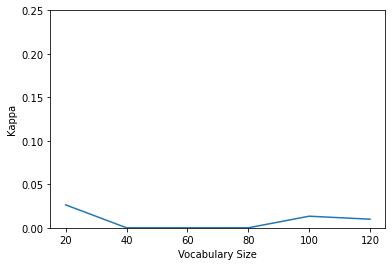

In [ ]:
plt.plot(sizes_to_test, kappa_results)
plt.ylim(0, 0.25)
plt.ylabel("Kappa")
plt.xlabel("Vocabulary Size")
plt.show()

#### **e. Tune hyperparameters**

In [ ]:
#insert code here
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

feature_name = list(unigram_df.columns[:-1])

X = unigram_df.loc[:, feature_name]
y = unigram_df['sentiment']

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, cv = 10, verbose = 3)

# fitting the model for grid search
grid.fit(X, y)

print(f'The best parameters for the model could be: {grid.best_params_}.')
print(f'The score of the model with the best parameters is {grid.best_score_}.')

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 2/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 3/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 4/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 5/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 6/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 7/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 8/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 9/10] END ....C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 10/10] END ...C=0.1, gamma=1, kernel=linear;, score=0.750 total time=   0.0s
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rb

# 2. Train models & report metrics

#### **a. Train two models on the held-out 20% test set**

##### A Naive Bayes classifier with unigram features

In [ ]:
# Split into training and testing data
x_2 = train['topic']
y_2 = train['labels_A']
x_test_2 = test['topic']
y_test_2 = test['labels_A']

In [ ]:
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x_2 = vec.fit_transform(x_2).toarray()
x_test_2 = vec.transform(x_test_2).toarray()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_2 = MultinomialNB()
model_2.fit(x_2, y_2)
y_pred_2 = model_2.predict(x_test_2)

##### The best-tuned model from task two, retrained on the full 80% training set.

In [ ]:
# Get the training data
X_3 = unigram_df.iloc[:, :-1]
X_3 = pd.get_dummies(X_3)
y_3 = unigram_df['sentiment']

# Set the parameters
model_3 = SVC(C=0.1, kernel='rbf', gamma=1, random_state=1)

# Fit the model with cetain parameter
model_3.fit(X_3, y_3)
y_pred_3 = model_3.predict(x_test_2)

SVC(C=0.1, gamma=1, random_state=1)

####**b. Report three sets of evaluation metrics:**
  

##### 1. The estimated performance from cross-validation.

In [ ]:
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score

# Get the training data
X_1 = unigram_df.iloc[:, :-1]
X_1 = pd.get_dummies(X_1)
y_1 = unigram_df['sentiment']

# Set the parameters and scoring metrics
param_grid = {'C': [0.1],
              'gamma': [1],
              'kernel':['rbf']}
scoring_metrics = {'accuracy': make_scorer(accuracy_score),
           'Kappa': make_scorer(cohen_kappa_score)}
model_1 = GridSearchCV(SVC(), param_grid, refit=False, cv=10, verbose=3, scoring=scoring_metrics)

# fitting the model for grid search
model_1.fit(X_1, y_1)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 2/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 3/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 4/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 5/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 6/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 7/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 8/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV 9/10] END C=0.1, gamma=1, kernel=rbf; Kappa: (test=0.000) accuracy: (test=0.750) total time=   0.0s
[CV

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1], 'gamma': [1], 'kernel': ['rbf']},
             refit=False,
             scoring={'Kappa': make_scorer(cohen_kappa_score),
                      'accuracy': make_scorer(accuracy_score)},
             verbose=3)

The accuracy of the best-tuned model from cross-validation in Task 2 is 0.75, and its Kappa value is 0.0.

##### 2. The performance of the simple Naïve Bayes unigram classifier on the held-out test set.

In [ ]:
from sklearn.metrics import classification_report

class_desc_2 = classification_report(y_test, y_pred, output_dict=False)
print(class_desc_2)

              precision    recall  f1-score   support

    negative       0.17      0.09      0.12        11
    positive       0.71      0.83      0.76        29

    accuracy                           0.62        40
   macro avg       0.44      0.46      0.44        40
weighted avg       0.56      0.62      0.58        40



In [ ]:
# Set a list of metrics I want to use to compare classifiers
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

evaluate(y_pred_2, y_test_2, metrics)

(array([[ 1, 10],
        [ 5, 24]]), {'Accuracy': 62.5, 'Kappa': -0.0948905109489051})

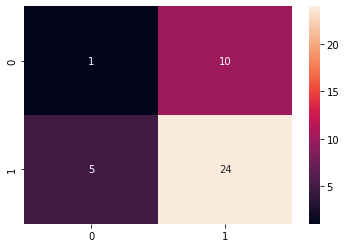

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(conf_matrix_2, annot=True)

The percent accuracy of the simple Naïve Bayes unigram classifier is 62.5, and its Kappa value is -0.095.

##### 3. The performance of the best-tuned model on the held-out test set.

In [ ]:
# Set a list of metrics I want to use to compare classifiers
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

evaluate(y_pred_3, y_test_2, metrics)

(array([[ 0, 11],
        [ 0, 29]]), {'Accuracy': 72.5, 'Kappa': 0.0})

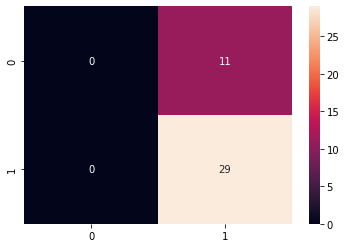

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix_3 = confusion_matrix(y_test_2, y_pred_3)
sns.heatmap(conf_matrix_3, annot=True)

The percent accuracy of the best-tuned model on the held-out test set is 72.5, and its Kappa value is 0.0.